 # PROJECT TO APPLY TEXT DOCUMENTS CLUSTRING

#### Meties Bootcamp ,  Project 4 - Lubna Alhenaki

![Alt Text](https://media.giphy.com/media/3UefM0f85ubQs/giphy.gif)

## Introduction

In recent years, the volume of information in digital form has increased tremendously owing to the increased popularity of the World Wide Web. As a result, the use of techniques for extracting useful information from large collections of data, and particularly documents, has become more necessary and challenging.

Text clustering is such a technique; it consists in dividing a set of text documents into clusters (groups), so that documents within the same cluster are closely related, whereas documents in different clusters are as different as possible.

In this project, the K-means will be use to perform clustering process . To evaluate the effectiveness, the clustring algorithm will be test on a well-known text document dataset: the“20Newsgroup” dataset from the University of California Irvine Machine Learning
Repository.

 ## Text Documents Dataset

It contains approximately 20,000 newsgroup articles, divided across 20 different newsgroup categories, such as rec.autos, rec.motorcycles, rec.sport.baseball, and rec.sport.hockey (sports category). For more details please visit http://qwone.com/~jason/20Newsgroups/

In [40]:
import umap
import matplotlib.pyplot as plt
import string 
import re 
import pandas as pd
import numpy as np



from sklearn.datasets import fetch_20newsgroups #load dataset
from nltk.tokenize import word_tokenize #pre-processing (toknization)
from nltk.corpus import stopwords #pre-processing (remove stopwords)
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,NMF
from sklearn.cluster import KMeans 
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
from itertools import cycle, islice
from yellowbrick.text import UMAPVisualizer

from yellowbrick.style import set_palette # gives you more colors to work with 

set_palette('paired')

In [2]:
 #!pip install yellowbrick

### 1- Load the dataset of 20Newsgroup posts


**Data Inspection**
* What data type is data?
* How many data documents does dataset contain?
* Inspect the first data point, what does it look like?
* How many data documents of each category does dataset contain?



In [3]:
data=fetch_20newsgroups(subset='all',shuffle=True,remove=('headers', 'footers', 'quotes'))

In [4]:
documents=data.data

In [5]:
categories=data.target_names

In [6]:
target=data.target

In [7]:
target.shape

(18846,)

In [8]:
categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [9]:
type(documents)

list

In [10]:
len(documents)

18846

In [11]:
documents[0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [ ]:

#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
df = pd.DataFrame(data=data.target, columns=['category'])
sum = df['category'].groupby(df['category']).count()
sum.index = categories
sum.plot(kind = 'bar',figsize=(10, 5),color=np.random.rand(len(df),4))
plt.title('Distribution of Documents in Each Category')
plt.xlabel('Category Name')
plt.ylabel('Number of Documents')
plt.xticks(rotation=50)
plt.show()

In [13]:
sum

alt.atheism                 799
comp.graphics               973
comp.os.ms-windows.misc     985
comp.sys.ibm.pc.hardware    982
comp.sys.mac.hardware       963
comp.windows.x              988
misc.forsale                975
rec.autos                   990
rec.motorcycles             996
rec.sport.baseball          994
rec.sport.hockey            999
sci.crypt                   991
sci.electronics             984
sci.med                     990
sci.space                   987
soc.religion.christian      997
talk.politics.guns          910
talk.politics.mideast       940
talk.politics.misc          775
talk.religion.misc          628
Name: category, dtype: int64

### 2- Pre-processing Steps

**Data cleaning steps on all documents:**
* Make all text lower case
* Remove punctuation
* Remove numerical values
* Remove special character 
* Tokenize text
* Remove stop words

**More data cleaning steps after tokenization:**
* Porter Stemming 

**2.1 Setup**

In [14]:
def preprocessing(docs):
    docs_clean=[]
    
    for i in range(0,len(docs)):
        docs[i]=docs[i].lower() #remove capital letters
        docs[i]= re.sub('\w*\d\w*', ' ', docs[i]) #remove numbers
        docs[i]= re.sub('[%s]' % re.escape(string.punctuation), ' ', docs[i])  # remove punctuation
        #print(docs[i])
        docs_clean.append(word_tokenize(docs[i])) #word tokenization\

    return  docs_clean

In [15]:
def stem(words):
    porterstemmer=PorterStemmer()
    return ' '.join([porterstemmer.stem(word) for word in words])

In [16]:
stopword=stopwords.words('english')

**2.2 Execute**

In [17]:
clean_documents=preprocessing(documents)

In [18]:
final_cleans=[ stem(clean_doc) for clean_doc in clean_documents]

In [19]:
final_cleans[0]

'i am sure some basher of pen fan are pretti confus about the lack of ani kind of post about the recent pen massacr of the devil actual i am bit puzzl too and a bit reliev howev i am go to put an end to non pittsburgh relief with a bit of prais for the pen man they are kill those devil wors than i thought jagr just show you whi he is much better than hi regular season stat he is also a lot fo fun to watch in the playoff bowman should let jagr have a lot of fun in the next coupl of game sinc the pen are go to beat the pulp out of jersey anyway i wa veri disappoint not to see the island lose the final regular season game pen rule'

### 3-Extract Feature Vectors That Is Suitable For Clustering purpose ( Vectorize)

Why I don't use TF (CountVectorizer)? 
    Because counting the number of words in each document will give more weightage to longer documents than shorter documents. To avoid this, I use TF-IDF

In [20]:


tfidf_vector=TfidfVectorizer(stop_words=stopword, lowercase=False,min_df=500)
# when I used  integer value for min_df parameters it will choose the cutoff on an absolute value that means
# ,for example, the word”Lubna” appears at least 20 times in all documents
#scaler = StandardScaler(with_mean=False)
#scaler=preprocessing.MaxAbsScaler()



# When I used float it means min_df=0.1, for example, the word “Lubna” most be at least appears at 10% of whole
# documents


tfidf_docs=tfidf_vector.fit_transform(final_cleans)
normlize_df=normalize(tfidf_docs).toarray()

#scaled_df = scaler.fit_transform(tfidf_docs).toarray() 


In [21]:
type(normlize_df)

numpy.ndarray

In [22]:
df_tfidf=pd.DataFrame(data=normlize_df,columns=tfidf_vector.get_feature_names())
df_tfidf.head()

,abl,abov,accept,access,act,action,activ,actual,ad,add,...,wonder,word,work,world,would,write,wrong,ye,year,yet
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.138922,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.11155,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.0,0.151939,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.110179,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


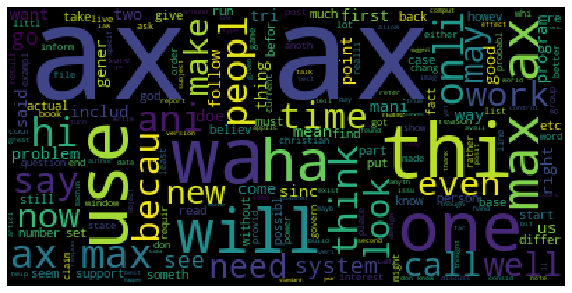

In [116]:
text=' '.join(word for word in final_cleans)

wordcloud=WordCloud( max_words=200).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 4-Dimensiona Reduction / Topic Modeling

High dimensionality is challenging to perform a efficient clusters of the input documents, by using high dimensionality reduction techniques we can reduce the size of the vector space model.In this project, I selected the Singular Value Decomposition (SVD) dimensionality reduction technique (linear dimensionality reduction ) because it's proved as an effective technique as the following study: 
* Text Document Preprocessing and Dimension Reduction Techniques for Text Document Clustering
* A Comparative Study of Dimensionality Reduction Techniques to Enhance Trace Clustering Performances

Furthermore,storing the data and processing time of trace clustering is effectively reduced with dimensionality reduction techniques.



 

In [24]:
def top_word_topic(model,features,number_top_features):
    for i, comp in enumerate(model.components_):
        features_comp = zip(features, comp)
        sorted_terms = sorted(features_comp, key= lambda x:x[1], reverse=True)[:number_top_features]
        print('\n \n','** Topic '+str(i))
        for word in (sorted_terms):
             print(word[0], end =", ")


## 4.1 Baseline

**Steps:**

* Victorize using TFIDF (min_df=500)
* Normlize (default by TFIDF)
* SVD (# of component=20)


In [55]:
SVD=TruncatedSVD( n_components=20) #Singular Value Decomposition (SVD) 
SVD.fit(df_tfidf)
baseline_trans_data=SVD.transform(df_tfidf)
terms = tfidf_vector.get_feature_names()

In [56]:
# plt.plot(np.cumsum(SVD.explained_variance_ratio_))
# #plt.xlim([900,950])

In [57]:
SVD.explained_variance_ratio_.sum()

0.05103867178478149

Since the data comes from 20 different newsgroups, I set the topics=20 for our text data. The number of topics can be specified by using the n_components parameter.

In [58]:


# X_topics = SVD.fit_transform(df_tfidf)
# embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

# plt.figure(figsize=(7,5))
# plt.scatter(embedding[:, 0], embedding[:, 1], 
# c = data.target,
# s = 10, # size
# edgecolor='none'
# )
# plt.show()

In [59]:
top_word_topic(SVD, terms,10) 


 
 ** Topic 0
peopl, think, hi, time, doe, say, onli, make, go, work, 
 
 ** Topic 1
window, thank, file, card, drive, program, pleas, driver, run, disk, 
 
 ** Topic 2
game, team, year, drive, play, player, car, last, go, season, 
 
 ** Topic 3
drive, scsi, disk, ide, control, hard, card, chip, key, system, 
 
 ** Topic 4
key, encrypt, chip, govern, clipper, secur, escrow, phone, law, file, 
 
 ** Topic 5
pleas, thank, mail, anyon, post, email, address, edu, list, send, 
 
 ** Topic 6
key, game, chip, god, encrypt, clipper, card, bit, escrow, system, 
 
 ** Topic 7
drive, file, disk, format, scsi, program, game, hard, edu, floppi, 
 
 ** Topic 8
card, armenian, peopl, israel, game, jew, arab, govern, driver, isra, 
 
 ** Topic 9
edu, card, imag, sale, includ, offer, graphic, price, color, space, 
 
 ** Topic 10
window, god, car, mail, pleas, key, sale, new, price, offer, 
 
 ** Topic 11
hi, armenian, file, car, anyon, god, doe, key, year, turkish, 
 
 ** Topic 12
file, card, driver, 

**These topics have alot of overlapping terms, it is hard to understand any themes between them.
Let's lower the min_df to get more features**

## 4.2 Experiment  2

**Steps:**

* Victorize using TFIDF (min_df=10)
* Normlize(default by TFIDF)
* SVD (# of component=20)

### Vectorize

In [32]:
# changed to min_df = 10
tfidf_vector=TfidfVectorizer(stop_words=stopword, lowercase=False,min_df=10)
tfidf_docs=tfidf_vector.fit_transform(final_cleans)
normlize_df=normalize(tfidf_docs).toarray() 

df_tfidf=pd.DataFrame(data=normlize_df, columns=tfidf_vector.get_feature_names())
df_tfidf.head(2)

,aa,aaa,aaron,ab,abandon,abbrevi,abc,abdomin,aberr,abid,...,zoo,zoom,zq,zr,zs,zu,zuma,zv,zx,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reduce Dimensions

In [145]:
SVD=TruncatedSVD( n_components=20)
SVD.fit(df_tfidf)
trans_data=SVD.transform(df_tfidf)
terms = tfidf_vector.get_feature_names()
top_word_topic(SVD, terms,10)


 
 ** Topic 0
thi, wa, would, one, use, ani, get, know, like, ha, 
 
 ** Topic 1
window, file, thank, use, card, drive, program, pleas, driver, run, 
 
 ** Topic 2
game, wa, team, year, drive, play, player, car, last, get, 
 
 ** Topic 3
drive, key, scsi, chip, use, system, encrypt, disk, govern, control, 
 
 ** Topic 4
drive, god, scsi, card, thank, christian, hi, pleas, jesu, disk, 
 
 ** Topic 5
window, file, god, wa, run, drive, problem, driver, disk, use, 
 
 ** Topic 6
wa, armenian, car, window, thank, bike, kill, israel, gun, file, 
 
 ** Topic 7
wa, file, drive, edu, game, mail, pleas, armenian, key, disk, 
 
 ** Topic 8
card, wa, key, chip, anyon, driver, video, doe, monitor, hi, 
 
 ** Topic 9
drive, file, would, anyon, know, scsi, thank, ani, doe, key, 
 
 ** Topic 10
wa, key, god, car, use, chip, bike, encrypt, hi, jesu, 
 
 ** Topic 11
thi, post, problem, read, group, test, monitor, articl, card, newsgroup, 
 
 ** Topic 12
window, thi, pleas, mail, key, post, car, drive, 

In [149]:
(trans_data).sum(axis=0)

array([ 2.50116383e+03,  8.01920445e+01,  6.69016422e+01, -2.06636942e+01,
        9.18716330e+00, -2.73409069e+01,  7.44853926e+00,  3.10191530e+01,
       -3.31720576e+01, -5.79196778e+01, -1.39046591e+01, -2.53019925e+01,
       -8.35870243e+00,  8.98500009e+00,  1.49661603e+01,  2.78564173e+01,
       -8.44333505e+00,  1.45432912e+01, -2.49113242e+00, -1.05010784e+00])

In [154]:
((SVD.components_.T)**2).sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [160]:
((SVD.components_.T)**2).sum(axis=1).max()

0.8074561150282202

**Still kind of indistinct, but Topic 14 seems very specific and there is a greater diversity of terms because the vocabulary is larger** 

Let's see another model with the same data to see if it produces better topics.

## 4.3 Experiment  3


* Victorize using TFIDF (min_df=10)
* Normlize(default by TFIDF)
* NMF (# of component=20)

In [41]:
# NMF default solver will take longer than SVD to fit
# NMF is also creates approximate decompositions,may we got a different results each time 
# Non-negative Matrix Factorization(NMF)
nmf=NMF(n_components=20, random_state=20)
trans_data=nmf.fit_transform(df_tfidf)
terms = tfidf_vector.get_feature_names()
top_word_topic(nmf, terms, 10)


 
 ** Topic 0
get, think, one, go, like, thing, want, good, say, peopl, 
 
 ** Topic 1
would, like, ani, appreci, could, help, greatli, someon, look, also, 
 
 ** Topic 2
game, team, play, player, win, year, hockey, score, basebal, season, 
 
 ** Topic 3
drive, scsi, disk, hard, ide, floppi, control, boot, system, hd, 
 
 ** Topic 4
god, christian, jesu, believ, bibl, hi, sin, christ, faith, exist, 
 
 ** Topic 5
window, run, program, ms, os, applic, font, manag, version, server, 
 
 ** Topic 6
key, chip, encrypt, clipper, escrow, secur, phone, bit, algorithm, govern, 
 
 ** Topic 7
space, system, imag, program, graphic, comput, data, inform, avail, softwar, 
 
 ** Topic 8
card, driver, video, monitor, color, bu, vga, mode, graphic, bit, 
 
 ** Topic 9
sale, price, offer, new, sell, ship, includ, condit, ask, manual, 
 
 ** Topic 10
armenian, israel, jew, arab, muslim, isra, turkish, kill, genocid, jewish, 
 
 ** Topic 11
thi, post, group, ha, read, question, discuss, newsgroup, true,

In [144]:
(trans_data).sum(axis=0)

Topic0     170.293982
Topic1     101.196474
Topic2     114.318132
Topic3      69.524277
Topic4      67.099361
Topic5     145.645957
Topic6      72.407035
Topic7      83.159884
Topic8      54.423109
Topic9     116.347192
Topic10     74.999107
Topic11     48.688697
Topic12     70.916354
Topic13     49.758550
Topic14    133.300276
Topic15     93.212058
Topic16    128.634984
Topic17     99.968347
Topic18    172.014070
Topic19     84.270142
dtype: float64

We can obsierve that more distinct! The computer terms are not mixed with religious terms any more.  Sports are with sports. etc. Therefore, I use NMF instead of SVD.

I'd like to see whether setting a `max_df` will remove some terms like "also" and "said", we could do this by adding them to the stop_words list, but max_df will be an easier, more automated fix.

## 4.4 Experiment  4 

**Steps:**
* Victorize using TFIDF (min_df=10,max_df=.5)
* Normlize(default by TFIDF)
* NMF (# of component=20)

### Vectorize

In [91]:
# changed to min_df = 10 and max_df of 50%
tfidf_vector=TfidfVectorizer(stop_words=stopword, lowercase=False,min_df=10, max_df=.5)
tfidf_docs=tfidf_vector.fit_transform(final_cleans)
#normlize_df=normalize(tfidf_docs).toarray() <--- I removed this because tf-idf already encompasses a type of normalization

df_tfidf=pd.DataFrame(data=tfidf_docs.todense(), columns=tfidf_vector.get_feature_names())
df_tfidf.head(2)

,aa,aaa,aaron,ab,abandon,abbrevi,abc,abdomin,aberr,abid,...,zoo,zoom,zq,zr,zs,zu,zuma,zv,zx,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice that this is the same shape as when I didn't have a max_df, so 50% doesn't change our vocab.  Let's try moving it even lower.

In [43]:
# changed to min_df = 10 and max_df of 30%
tfidf_vector=TfidfVectorizer(stop_words=stopword, lowercase=False,min_df=10, max_df=.2)
tfidf_docs=tfidf_vector.fit_transform(final_cleans)
#normlize_df=normalize(tfidf_docs).toarray() <--- I removed this because tf-idf already encompasses a type of normalization

df_tfidf=pd.DataFrame(data=tfidf_docs.todense(), columns=tfidf_vector.get_feature_names())
df_tfidf.head(2)

,aa,aaa,aaron,ab,abandon,abbrevi,abc,abdomin,aberr,abid,...,zoo,zoom,zq,zr,zs,zu,zuma,zv,zx,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reduce Dimensions

In [44]:
%%time
#Non-negative Matrix Factorization(NMF)
nmf=NMF(n_components=20, random_state=20)
trans_data=nmf.fit_transform(df_tfidf)
terms = tfidf_vector.get_feature_names()
top_word_topic(nmf, terms, 10)
#nmf.reconstraction_err_ to select best number of component , lower number is better 


 
 ** Topic 0
think, peopl, say, thing, go, whi, make, see, want, good, 
 
 ** Topic 1
problem, work, run, tri, system, machin, fix, time, error, fine, 
 
 ** Topic 2
game, team, play, year, player, win, hi, hockey, season, score, 
 
 ** Topic 3
drive, scsi, disk, hard, ide, floppi, control, boot, meg, hd, 
 
 ** Topic 4
god, christian, jesu, hi, believ, bibl, sin, christ, faith, church, 
 
 ** Topic 5
pleas, mail, post, list, address, email, send, repli, thank, edu, 
 
 ** Topic 6
key, chip, encrypt, clipper, escrow, secur, phone, bit, algorithm, govern, 
 
 ** Topic 7
file, format, program, ftp, convert, gif, directori, zip, imag, disk, 
 
 ** Topic 8
israel, arab, jew, isra, jewish, palestinian, state, kill, peac, war, 
 
 ** Topic 9
sale, price, offer, new, sell, ship, condit, includ, ask, best, 
 
 ** Topic 10
window, run, program, ms, applic, os, font, manag, version, app, 
 
 ** Topic 11
armenian, turkish, muslim, genocid, armenia, turk, turkey, peopl, russian, soviet, 
 
 ** T

In [256]:
trans_data=pd.DataFrame(trans_data,columns=['Topic{}'.format(c)for c in range(20)])
#trans_data.sum(axis=1)
trans_data

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19
0,0.140775,-0.060377,0.156950,-0.092780,-0.009174,0.021312,-0.112827,0.023321,0.009652,0.027311,-0.019178,-0.006190,-0.015085,0.020889,-0.009980,-0.003694,-0.021449,0.014209,-0.035523,0.017470
1,0.120529,0.173893,-0.002629,-0.027704,0.128370,-0.052883,-0.015604,-0.040175,0.251481,-0.104955,-0.147703,0.018911,-0.038849,0.086671,-0.076892,-0.020678,0.088055,-0.062546,0.031143,0.082653
2,0.171556,-0.104033,0.017275,0.029305,-0.051022,0.002489,0.123772,0.058559,0.037512,0.001276,-0.148641,-0.103177,-0.011552,0.067707,0.107882,-0.028066,-0.106080,-0.070002,-0.053456,0.051747
3,0.109208,0.116833,0.028143,0.141671,0.088034,0.052332,-0.048718,0.053394,0.075722,0.039281,-0.070911,0.049184,-0.037770,0.020154,-0.026744,0.033691,0.029130,-0.030531,0.027425,0.116493
4,0.230053,0.191465,0.010557,0.164757,0.116151,0.037414,-0.022532,0.027116,0.004320,0.124060,0.054968,0.013351,-0.027080,0.024013,0.136564,0.014986,0.071564,0.092669,-0.004819,0.035921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0.127026,-0.030076,0.006775,0.014545,-0.020246,-0.003980,-0.000770,-0.034077,-0.045719,-0.018776,-0.014391,0.025787,-0.024174,0.005343,-0.028368,0.050734,-0.024844,-0.018948,-0.007746,0.026105
18842,0.054130,0.039358,-0.001672,0.022946,-0.021731,0.025919,0.002893,-0.016260,-0.005935,-0.039379,0.017367,0.027146,-0.038149,-0.021037,0.028847,-0.003142,-0.022085,0.027204,0.014202,-0.021375
18843,0.078197,0.017420,0.047475,0.047956,0.011296,0.025871,0.003459,-0.001221,0.055833,-0.008644,0.038445,0.028377,-0.000036,-0.020273,0.011454,0.010616,-0.039397,0.015681,0.002226,-0.004963
18844,0.126520,-0.037001,-0.041715,0.008802,-0.028140,0.012276,-0.028528,0.005612,-0.036622,-0.000039,-0.015430,0.133241,-0.002292,-0.031928,0.039219,-0.017074,0.026301,-0.018026,0.011752,0.068298


This looks more or less the same.  It doesn't seem to have negatively affected the topics, so I'm just going to keep the max_df in.  It only removed 10 words anyway.

In [156]:
((nmf.components_.T)**2).sum(axis=0) #check if vectores normlize or not , SVD normlze while NMF not

array([27.7237124 , 14.55065094, 11.81253326, 12.13116338, 27.00867961,
        6.69645952, 11.43196218,  8.42306054, 10.7740787 ,  8.31411413,
       13.45302317, 10.91825536,  9.55930045,  6.57824461, 10.12058309,
        6.8588307 ,  6.81559121,  8.96482688,  6.90158106,  5.87475893])

### 5- Clustering Text Documents

In [47]:
number_of_cluster=20 #silhouette analysis funcation on KMeans clustering used to select the best number of cluster

k_means=KMeans(n_clusters=number_of_cluster)
cluster_model=k_means.fit(trans_data)

In [48]:
cluster_model.labels_

array([ 1, 11, 14, ...,  0,  4, 15], dtype=int32)

In [50]:
cluster_model.fit_predict(trans_data)

array([13,  8, 17, ..., 10, 19,  0], dtype=int32)

In [292]:
pd.Series(cluster_model.labels_).value_counts() #check how many documents in each cluster

11    4781
13    2024
3     1896
16    1606
1      951
18     924
9      906
5      745
12     735
7      592
2      505
15     474
8      452
4      451
14     430
6      426
0      369
10     343
17     163
19      73
dtype: int64

/Users/Mony/.local/lib/python3.7/site-packages/umap_learn-0.3.10-py3.7.egg/umap/spectral.py:229: UserWarning: Embedding a total of 20 separate connected components using meta-embedding (experimental)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to sp

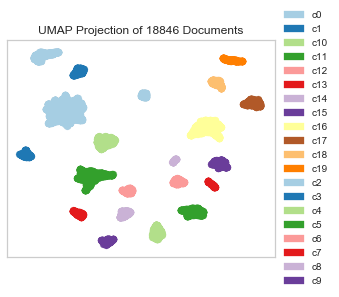

In [68]:
cliuster_umap=UMAPVisualizer().fit(trans_data,["c{}".format(c)for c in cluster_model.labels_])
cliuster_umap.show()

In [293]:
# #print top word in each cluster
# order_centroids = cluster_model.cluster_centers_.argsort()[:, ::-1]
# terms = tfidf_vector.get_feature_names()
# for i in range(number_of_cluster):
#     print("Cluster %d:" % i),
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind])

### 5.1 Compared against Baseline:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

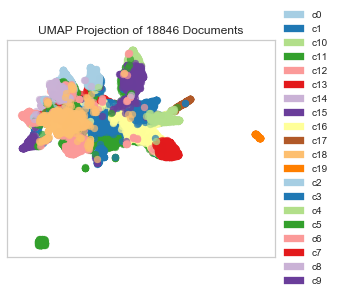

In [69]:
number_of_cluster=20
k_means=KMeans(n_clusters=number_of_cluster)
# replacing trans_data with baseline_trans_data
cluster_model=k_means.fit(baseline_trans_data)
# same here
cliuster_umap=UMAPVisualizer().fit(baseline_trans_data,["c{}".format(c)for c in cluster_model.labels_])
cliuster_umap.show()

So the previous version with NMF looks a little more distinct.  

So, we must go iteratively trying to get more distinct clusters - change one aspect of the inputs at a time (number of features) , explore the results, see if it helped or hurt.  Also, measuring such as silhouette scores could be used.

### 5.2 Let’s Inspect The Results of Clustering . What Is Each Cluster Talking About? 


In [257]:
trans_data['Cluster_lable']=cluster_model.labels_

In [261]:
trans_data.columns

Index(['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6',
       'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12',
       'Topic13', 'Topic14', 'Topic15', 'Topic16', 'Topic17', 'Topic18',
       'Topic19', 'Cluster_lable'],
      dtype='object')

In [122]:
df_mean=trans_data.groupby(trans_data.Cluster_lable).mean()

In [161]:
df_mean

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19
Cluster_lable,,,,,,,,,,,,,,,,,,,,
0,0.014561,0.003370,0.002206,0.001020,0.001701,0.003339,0.004304,0.000996,0.002993,0.003022,0.000565,0.003162,0.000845,0.001410,0.003310,0.000769,0.066003,0.002822,0.006306,0.001037
1,0.005619,0.005461,0.001331,0.005308,0.000674,0.005392,0.001420,0.000795,0.000776,0.009440,0.001882,0.000556,0.001961,0.001159,0.005409,0.000866,0.002935,0.077173,0.004192,0.001210
2,0.005041,0.002109,0.002545,0.000728,0.001369,0.003499,0.001360,0.001149,0.001452,0.002922,0.000682,0.001440,0.000823,0.001861,0.002100,0.002018,0.004174,0.002309,0.006439,0.001288
3,0.003897,0.010220,0.001447,0.004602,0.000602,0.009321,0.002246,0.004375,0.000284,0.007625,0.010007,0.000334,0.085335,0.001789,0.013433,0.014007,0.000858,0.001204,0.004491,0.027107
4,0.024481,0.003213,0.001434,0.000494,0.014285,0.006214,0.001055,0.001086,0.004529,0.002523,0.000412,0.003118,0.000371,0.001233,0.003925,0.000567,0.005717,0.000549,0.008600,0.000893
5,0.006159,0.015710,0.001666,0.002428,0.000617,0.005050,0.004058,0.005449,0.000579,0.003780,0.005526,0.000605,0.003239,0.001467,0.006505,0.010417,0.001825,0.002239,0.026556,0.014498
6,0.004671,0.012231,0.001382,0.089923,0.000431,0.007719,0.001821,0.005086,0.000392,0.010795,0.002984,0.000462,0.010373,0.001076,0.009280,0.012575,0.001526,0.002108,0.004247,0.005015
7,0.009143,0.003489,0.001084,0.000854,0.000623,0.005006,0.094705,0.003943,0.001035,0.003350,0.001093,0.000778,0.000760,0.001175,0.003920,0.004257,0.010865,0.001825,0.007686,0.001740
8,0.013765,0.002524,0.001791,0.000447,0.058313,0.003025,0.000659,0.000748,0.001882,0.002007,0.000265,0.001571,0.000245,0.001189,0.004486,0.000396,0.004105,0.001308,0.003165,0.000800


In [162]:
df_cluster_topic=pd.Series(zip(df_mean.idxmax(axis=1),df_mean.max(axis=1)/df_mean.sum(axis=1)))

In [163]:
df_cluster_topic

0      (Topic16, 0.5333898483204822)
1      (Topic17, 0.5778117690232055)
2     (Topic18, 0.14211048089085163)
3      (Topic12, 0.4199896723721484)
4        (Topic0, 0.289032976794264)
5     (Topic18, 0.22434240835356833)
6      (Topic3, 0.48845871312337347)
7       (Topic6, 0.6019481503693819)
8        (Topic4, 0.567864289611895)
9     (Topic10, 0.44897773169378496)
10      (Topic2, 0.4643879016746814)
11       (Topic9, 0.323133284201576)
12     (Topic7, 0.48186616961112616)
13     (Topic11, 0.7499213548831913)
14     (Topic13, 0.9096627278952304)
15     (Topic14, 0.4268529307868913)
16     (Topic0, 0.20715168073135912)
17      (Topic5, 0.4748226315472684)
18      (Topic2, 0.7079990666462204)
19      (Topic8, 0.6071781258204209)
dtype: object

In [242]:
def order(row):
    row=row.sort_values(ascending=False)/row.sum()
    return pd.Series([ (i,round(row[i]*100,2)) for i in row.index[:3]])

df_ratio_cluster=df_mean.apply(order,axis=1)

In [288]:
df_ratio_cluster

,0,1,2
Cluster_lable,,,
0,"(Topic16, 53.34)","(Topic0, 11.77)","(Topic18, 5.1)"
1,"(Topic17, 57.78)","(Topic9, 7.07)","(Topic0, 4.21)"
2,"(Topic18, 14.21)","(Topic0, 11.13)","(Topic16, 9.21)"
3,"(Topic12, 42.0)","(Topic19, 13.34)","(Topic15, 6.89)"
4,"(Topic0, 28.9)","(Topic4, 16.87)","(Topic18, 10.15)"
5,"(Topic18, 22.43)","(Topic1, 13.27)","(Topic19, 12.25)"
6,"(Topic3, 48.85)","(Topic15, 6.83)","(Topic1, 6.64)"
7,"(Topic6, 60.19)","(Topic16, 6.91)","(Topic0, 5.81)"
8,"(Topic4, 56.79)","(Topic0, 13.4)","(Topic14, 4.37)"


In [236]:
def order1(row):
    return pd.Series([ row[i][1] for i in row.index])

df_ratio_sum=df_ratio_cluster.apply(order1,axis=1)

In [239]:
df_ratio_sum.sum(axis=1)

Cluster_lable
0     1.00
1     1.00
2     1.01
3     1.00
4     1.00
5     0.99
6     1.02
7     1.00
8     0.99
9     1.00
10    1.00
11    0.98
12    0.99
13    0.98
14    0.97
15    1.01
16    1.00
17    0.99
18    1.02
19    1.00
dtype: float64

In [302]:
test1=np.where(trans_data.Cluster_lable== 12)
pd.DataFrame(test1)

,0,1,2,3,4,5,6,7,8,9,...,725,726,727,728,729,730,731,732,733,734
0,49,72,83,109,129,138,173,174,180,190,...,18544,18550,18555,18612,18626,18629,18648,18724,18736,18763


In [303]:
trans_data.iloc[49]

Topic0            0.112647
Topic1            0.180891
Topic2           -0.043639
Topic3           -0.124107
Topic4            0.001962
Topic5           -0.130789
Topic6            0.037484
Topic7            0.090247
Topic8           -0.004734
Topic9           -0.033414
Topic10          -0.013869
Topic11          -0.084712
Topic12           0.150639
Topic13          -0.031853
Topic14          -0.009009
Topic15          -0.028197
Topic16          -0.037050
Topic17           0.006541
Topic18           0.026056
Topic19           0.079050
Cluster_lable    12.000000
Name: 49, dtype: float64

In [304]:
documents[49]

'i am looking for the exact address of the symantec coporatoin  which \ndistributes norton desktop and other windows software \n\nthe information i am looking for is \n\nmail address\nphone number\nfax number\ne mail address\n\nthanks in advance \n'

In [306]:
final_cleans[49]

'i am look for the exact address of the symantec coporatoin which distribut norton desktop and other window softwar the inform i am look for is mail address phone number fax number e mail address thank in advanc'

In [295]:
# df_mean_L1=df_mean/df_mean.sum(axis=1).values.reshape(-1,1)
# df_mean_L1

### Convert into Classification Problems 

In [70]:
cluster_model.labels_

array([ 4, 14, 17, ..., 11, 13, 15], dtype=int32)

In [71]:
pd.Series(cluster_model.labels_).value_counts()

11    4781
13    2024
3     1896
16    1606
1      951
18     924
9      906
5      745
12     735
7      592
2      505
15     474
8      452
4      451
14     430
6      426
0      369
10     343
17     163
19      73
dtype: int64

In [72]:
pd.DataFrame()

""


In [73]:
(cluster_model.labels_==12).shape

(18846,)

In [74]:
[cluster_model.cluster_centers_[i].argmax() for i in range(20)]

[4, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 5, 0, 1, 0, 0, 8, 0, 13]

In [75]:
[categories[pd.Series(target[ cluster_model.labels_==i]).value_counts().index[0]] for i in range (20)]

['sci.crypt',
 'talk.politics.guns',
 'comp.os.ms-windows.misc',
 'rec.motorcycles',
 'rec.sport.hockey',
 'comp.sys.mac.hardware',
 'comp.sys.ibm.pc.hardware',
 'soc.religion.christian',
 'comp.graphics',
 'rec.sport.baseball',
 'talk.politics.mideast',
 'sci.med',
 'comp.graphics',
 'comp.windows.x',
 'comp.sys.ibm.pc.hardware',
 'rec.autos',
 'soc.religion.christian',
 'talk.politics.mideast',
 'misc.forsale',
 'sci.med']

In [76]:
pd.Series(target[ cluster_model.labels_==6]).value_counts()


#the cluster number 17,16..etc have this number of category 6 

3     197
4     106
6      60
2      25
8      19
12     13
7       3
18      2
5       1
dtype: int64

In [77]:
clusters=[]
for i in range(20):
    freq_series=pd.Series(target[ cluster_model.labels_==i]).value_counts()
    cat_ind=freq_series.index[0]
    frac=freq_series[cat_ind]/freq_series.sum()
    #print(cat_ind)
    clusters.append((categories[cat_ind],frac))
    
clusters

[('sci.crypt', 0.9159891598915989),
 ('talk.politics.guns', 0.5152471083070452),
 ('comp.os.ms-windows.misc', 0.5227722772277228),
 ('rec.motorcycles', 0.2779535864978903),
 ('rec.sport.hockey', 0.6097560975609756),
 ('comp.sys.mac.hardware', 0.14496644295302014),
 ('comp.sys.ibm.pc.hardware', 0.4624413145539906),
 ('soc.religion.christian', 0.6097972972972973),
 ('comp.graphics', 0.38495575221238937),
 ('rec.sport.baseball', 0.45805739514348787),
 ('talk.politics.mideast', 0.9591836734693877),
 ('sci.med', 0.07969044133026564),
 ('comp.graphics', 0.12789115646258503),
 ('comp.windows.x', 0.18972332015810275),
 ('comp.sys.ibm.pc.hardware', 0.3813953488372093),
 ('rec.autos', 0.7974683544303798),
 ('soc.religion.christian', 0.24470734744707348),
 ('talk.politics.mideast', 1.0),
 ('misc.forsale', 0.5443722943722944),
 ('sci.med', 0.9863013698630136)]

In [86]:
pd.Series(target[ cluster_model.labels_==16]).value_counts()

15    393
0     345
19    207
18    184
13    122
17    113
11     52
16     43
14     33
9      22
1      19
7      13
10     12
2      11
8      11
12      6
6       6
5       6
3       5
4       3
dtype: int64

In [87]:
clusters=[]

freq_series=pd.Series(target[ cluster_model.labels_==16]).value_counts()
print(freq_series)
cat_ind=freq_series.index[0]
print("cat_ind",cat_ind)
print(freq_series.sum())
frac=freq_series[cat_ind]/freq_series.sum()
print(frac)
#print(cat_ind)
clusters.append((categories[cat_ind],frac))
    
clusters

15    393
0     345
19    207
18    184
13    122
17    113
11     52
16     43
14     33
9      22
1      19
7      13
10     12
2      11
8      11
12      6
6       6
5       6
3       5
4       3
dtype: int64
cat_ind 15
1606
0.24470734744707348


[('soc.religion.christian', 0.24470734744707348)]

In [88]:
categories[10]

'rec.sport.hockey'